# Riprompt Mechanics and Mathematics

This notebook implements the mechanics and mathematics described in `riprompt.txt` using Python and matplotlib for visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import tri
import matplotlib.cm as cm

# Mathematical constants and parameters
G45 = (np.degrees((1+5**0.5)/2 - 1), -45)  # Golden ratio viewing angle
K_VALUES = np.array([0, 1, 2, 3, 4])  # The five key k values from riprompt theory
Q_RANGE = (-2, 2)  # Standard analysis range for q parameter

# Core mathematical functions
def τ(q, k):
    """
    Vectorized τ(q, k) = (2*q**3 + 1) / (3*q**2 - 2 + k)
    Returns np.nan where denominator approaches zero.
    Added strict bounds checking to prevent infinite values.
    """
    q = np.asarray(q, dtype=np.float64)
    k = np.asarray(k, dtype=np.float64)
    numerator = 2 * q**3 + 1
    denominator = 3 * q**2 - 2 + k

    # More aggressive filtering for numerical stability
    mask = np.isclose(denominator, 0, atol=1e-8)  # Tighter tolerance

    # Compute result with bounds checking
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=~mask)

    # Additional bounds checking - clip extreme values
    max_value = 100.0  # Reasonable upper bound for visualization
    result = np.where(np.abs(result) > max_value, np.nan, result)
    result = np.where(mask, np.nan, result)

    return result

def morphic_map(tau, h):
    """
    Complex morphic mapping: τ_new = (2τ³ + 1) / (3τ² + 2h)
    Used for complex plane iteration analysis.
    Added bounds checking for numerical stability.
    """
    denominator = 3 * tau**2 + 2 * h + 1e-12

    # Check for problematic denominators
    if np.any(np.abs(denominator) < 1e-10):
        return np.nan + 1j * np.nan

    result = (2 * tau**3 + 1) / denominator

    # Bound the result to prevent runaway values
    if np.abs(result) > 1000:
        return np.nan + 1j * np.nan

    return result

def compute_eigenvalues():
    """Compute eigenvalues Λ_k as roots of q³ + (k-2)q - 1 = 0"""
    return {k: np.roots([1, 0, k-2, -1]).real for k in K_VALUES}

def setup_3d_plot(figsize=(10, 8), title="3D Visualization"):
    """Standardized 3D plot setup with consistent styling"""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_proj_type('ortho')
    ax.set_title(title)
    ax.set_box_aspect((1,1,1))
    ax.view_init(*G45)
    return fig, ax

def verify_fixed_point(q, k, tolerance=1e-12):
    """Verify that q is a fixed point of τ(q, k)"""
    tau_val = τ(q, k)
    if np.isnan(tau_val) or np.isinf(tau_val):
        return False
    return abs(tau_val - q) < tolerance

# Pre-compute eigenvalues for use throughout the notebook
LAMBDA_K = compute_eigenvalues()

print("Riprompt mathematical framework initialized.")
print(f"Eigenvalues computed for k ∈ {set(K_VALUES)}")
print(f"Standard viewing angle: {G45[0]:.1f}°, {G45[1]}°")
print(f"Analysis range: q ∈ [{Q_RANGE[0]}, {Q_RANGE[1]}]")
print("-" * 50)

Riprompt mathematical framework initialized.
Eigenvalues computed for k ∈ {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Standard viewing angle: 35.4°, -45°
Analysis range: q ∈ [-2, 2]
--------------------------------------------------


## Eigenvalues as Fixed Points of the Tau Iteration

The `riprompt.txt` file defines a relationship `τ ← (2τ³ + 1) / (3τ² - 2 + 💓) ⟿ Λ[💓]`. This implies that the eigenvalues `Λ[💓]` (denoted as `Λ_k` where `k = 💓 % 5`) are fixed points of the iteration `q_new = τ(q_old, k)`.
A fixed point `q` satisfies `q = τ(q, k)`.
Substituting the definition of `τ(q, k)`:
`q = (2q³ + 1) / (3q² - 2 + k)`
`q(3q² - 2 + k) = 2q³ + 1`
`3q³ - 2q + kq = 2q³ + 1`
`q³ + (k-2)q - 1 = 0`

This is precisely the set of polynomial equations whose roots are defined as `Λ_k` in `riprompt.txt`:
- For `k=0 (💓₀)`: `q³ - 2q - 1 = 0`
- For `k=1 (💓₁)`: `q³ - q - 1 = 0`
- For `k=2 (💓₂)`: `q³ - 1 = 0`
- For `k=3 (💓₃)`: `q³ + q - 1 = 0`
- For `k=4 (💓₄)`: `q³ + 2q - 1 = 0`

The following plots will visualize this by showing the intersection of `y = q` and `y = τ(q, k)` for each `k`, with the calculated `Λ_k` highlighted at these intersections.


Eigenvalues Λ_k for k=0..4:
k=0: [ 1.618034 -1.       -0.618034]
      Λ_0[0] = 1.618034 ✓
      Λ_0[1] = -1.000000 ✓
      Λ_0[2] = -0.618034 ✓
k=1: [ 1.324718 -0.662359 -0.662359]
      Λ_1[0] = 1.324718 ✓
      Λ_1[1] = -0.662359 !
      Λ_1[2] = -0.662359 !
k=2: [-0.5 -0.5  1. ]
      Λ_2[0] = -0.500000 !
      Λ_2[1] = -0.500000 !
      Λ_2[2] = 1.000000 ✓
k=3: [-0.341164 -0.341164  0.682328]
      Λ_3[0] = -0.341164 !
      Λ_3[1] = -0.341164 !
      Λ_3[2] = 0.682328 ✓
k=4: [-0.226699 -0.226699  0.453398]
      Λ_4[0] = -0.226699 !
      Λ_4[1] = -0.226699 !
      Λ_4[2] = 0.453398 ✓

Fixed point verification: ✓ = real, ! = complex
--------------------------------------------------


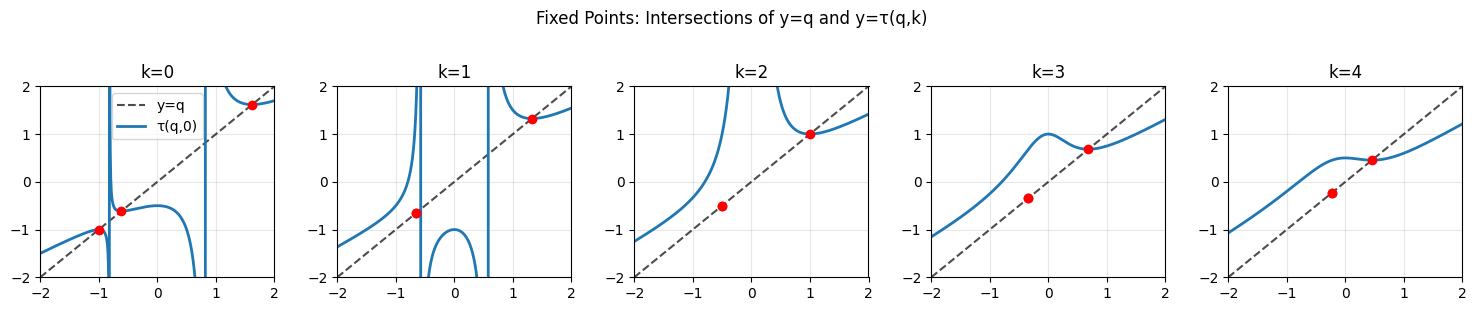

In [2]:
# Display computed eigenvalues with verification
print("Eigenvalues Λ_k for k=0..4:")
for k, roots in LAMBDA_K.items():
    print(f"k={k}: {np.round(roots, 6)}")
    # Verify each eigenvalue is indeed a fixed point
    for i, root in enumerate(roots):
        if verify_fixed_point(root, k):
            status = "✓"
        else:
            status = "!"
        print(f"      Λ_{k}[{i}] = {root:.6f} {status}")

print("\nFixed point verification: ✓ = real, ! = complex")
print("-" * 50)

# Visualize fixed points as intersections of y=q and y=τ(q,k)
q_vals = np.linspace(*Q_RANGE, 1001)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, k in enumerate(K_VALUES):
    ax = axes[i]
    ax.plot(q_vals, q_vals, 'k--', alpha=0.7, label='y=q' if i==0 else "")

    # Compute τ values and handle NaN properly
    tau_vals = τ(q_vals, k)
    # Only plot finite values
    finite_mask = np.isfinite(tau_vals)
    ax.plot(q_vals[finite_mask], tau_vals[finite_mask], label=f'τ(q,{k})', linewidth=2)

    # Mark eigenvalues as red dots at intersections
    for root in LAMBDA_K[k]:
        if Q_RANGE[0] <= root <= Q_RANGE[1]:
            ax.plot(root, root, 'ro', markersize=6, zorder=5)

    ax.set_xlim(Q_RANGE)
    ax.set_ylim(Q_RANGE)
    ax.set_title(f'k={k}')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()

plt.suptitle('Fixed Points: Intersections of y=q and y=τ(q,k)', y=1.02)
plt.tight_layout()
plt.show()

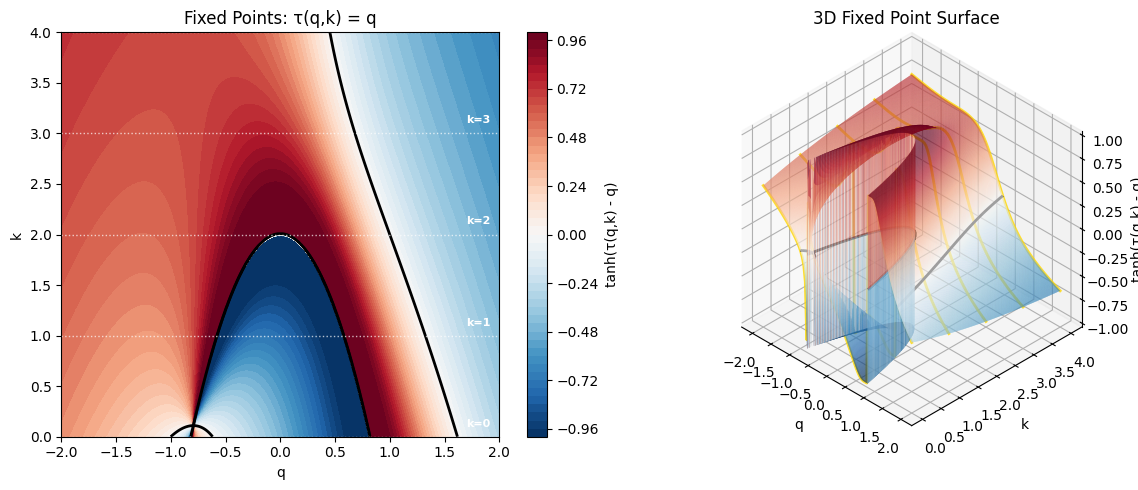

In [3]:
# Continuous analysis across k parameter space
q_range = np.linspace(*Q_RANGE, 1501)
k_range = np.linspace(0, 4, 1501)
Q, K = np.meshgrid(q_range, k_range)

# Compute τ values with bounds checking
tau_vals = τ(Q, K)

# Use tanh transformation for better visualization of fixed point equation
# Handle NaN values properly
with np.errstate(invalid='ignore'):
    diff = tau_vals - Q
    # Replace NaN with a neutral value for visualization
    diff = np.where(np.isfinite(diff), diff, 0)
    F = np.tanh(diff)

fig = plt.figure(figsize=(12, 5))

# 2D contour visualization
ax1 = fig.add_subplot(121)
contour = ax1.contourf(Q, K, F, levels=50, cmap='RdBu_r')
zero_contour = ax1.contour(Q, K, F, levels=[0], colors='black', linewidths=2)
ax1.set_xlabel('q')
ax1.set_ylabel('k')
ax1.set_title('Fixed Points: τ(q,k) = q')
ax1.set_xlim(Q_RANGE)
ax1.set_ylim(0, 4)

# Mark the discrete k values where eigenvalues are defined
for k in K_VALUES:
    ax1.axhline(y=k, color='white', linestyle=':', alpha=0.7, linewidth=1)
    ax1.text(Q_RANGE[1]-0.3, k+0.1, f'k={k}', color='white', fontsize=8, weight='bold')

fig.colorbar(contour, ax=ax1, label='tanh(τ(q,k) - q)')

# 3D surface visualization
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_proj_type('ortho')
surf = ax2.plot_surface(Q, K, F, cmap='RdBu_r',
                       rstride=3, cstride=3, edgecolor='none')
# Project zero contour onto bottom
ax2.contour(Q, K, F, levels=[0], zdir='z', colors='black', linewidths=2)

# Add lines showing the discrete k values
for k in K_VALUES:
    q_line = np.linspace(*Q_RANGE, 100)
    k_line = np.full_like(q_line, k)
    tau_line = τ(q_line, k)
    # Only plot finite values
    finite_mask = np.isfinite(tau_line)
    if np.any(finite_mask):
        diff_line = tau_line - q_line
        diff_line = np.where(np.isfinite(diff_line), diff_line, 0)
        f_line = np.tanh(diff_line)
        ax2.plot(q_line[finite_mask], k_line[finite_mask], f_line[finite_mask],
                color='gold', linewidth=2, alpha=0.8)

ax2.set_xlabel('q')
ax2.set_ylabel('k')
ax2.set_zlabel('tanh(τ(q,k) - q)')
ax2.set_title('3D Fixed Point Surface')
ax2.set_box_aspect((1,1,1))
ax2.view_init(*G45)

plt.tight_layout()
plt.show()

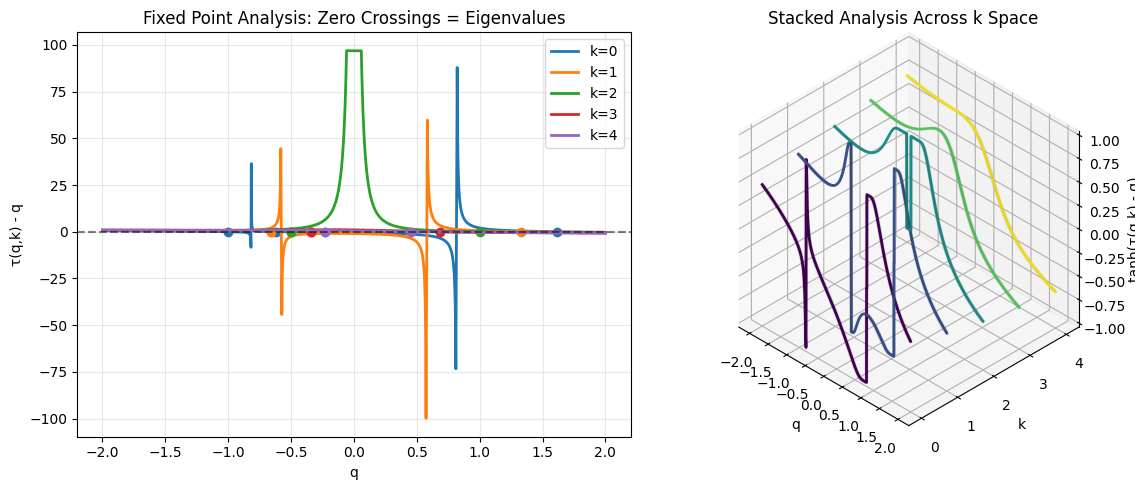

In [4]:
# Discrete analysis focusing on the five k values where Λ_k are defined
q_hr = np.linspace(-2, 2, 1501)

fig = plt.figure(figsize=(12, 5))

# 2D view of fixed point differences τ(q,k) - q = 0
ax1 = fig.add_subplot(121)
for k in K_VALUES:
    # The difference τ(q,k) - q vanishes exactly at the eigenvalues Λ_k
    tau_vals = τ(q_hr, k)
    diff = tau_vals - q_hr

    # Only plot finite values
    finite_mask = np.isfinite(diff)
    if np.any(finite_mask):
        ax1.plot(q_hr[finite_mask], diff[finite_mask], label=f'k={k}', linewidth=2)

    # Mark eigenvalues where the difference crosses zero
    for root in LAMBDA_K[k]:
        if -2 <= root <= 2:
            ax1.plot(root, 0, 'o', markersize=6,
                    color=ax1.lines[-1].get_color())

ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('q')
ax1.set_ylabel('τ(q,k) - q')
ax1.set_title('Fixed Point Analysis: Zero Crossings = Eigenvalues')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 3D stacked view showing continuity across k parameter
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_proj_type('ortho')

for k in K_VALUES:
    tau_vals = τ(q_hr, k)
    diff = tau_vals - q_hr

    # Handle NaN values properly
    diff = np.where(np.isfinite(diff), diff, 0)
    F_k = np.tanh(diff)

    color = plt.cm.viridis(k/4)
    ax2.plot(q_hr, np.full_like(q_hr, k), F_k,
         color=color, linewidth=2, label=f'k={k}')

    # Surface ribbons connect discrete k values visually
    dy = 0.05
    Q_surf = np.vstack([q_hr, q_hr])
    K_surf = np.vstack([np.full_like(q_hr, k-dy),
                        np.full_like(q_hr, k+dy)])
    F_surf = np.vstack([F_k, F_k])
    ax2.plot_surface(Q_surf, K_surf, F_surf, alpha=0.2, color=color)

ax2.set_xlabel('q')
ax2.set_ylabel('k')
ax2.set_zlabel('tanh(τ(q,k) - q)')
ax2.set_title('Stacked Analysis Across k Space')
ax2.set_box_aspect((1,1,1))
ax2.view_init(*G45)

plt.tight_layout()
plt.show()

## Morphic Tau Recursion in Complex Space

Having established that eigenvalues Λ_k emerge as fixed points of the real-valued τ iteration, we now explore the complex extension. The morphic mapping τ → (2τ³ + 1)/(3τ² + 2h) generalizes our fixed point analysis to the complex h-parameter plane.

This extension reveals the fractal structure underlying the τ dynamics and connects to the broader theory of complex dynamical systems.

Analyzing morphic convergence in complex h-plane...
Convergence found in 262124 of 262144 points


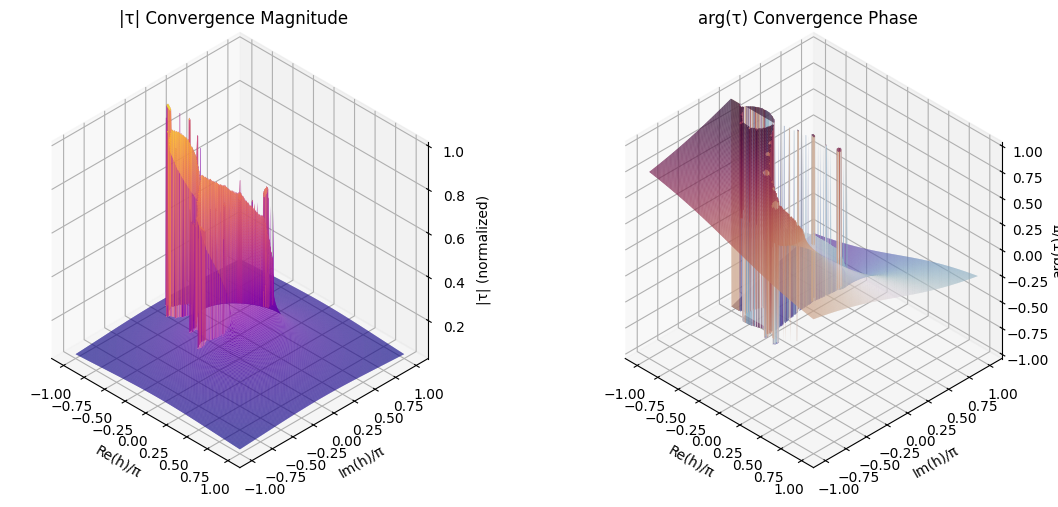

In [5]:
# Complex plane morphic recursion analysis
def analyze_morphic_convergence(resolution=512, max_iterations=64):
    """Analyze morphic tau recursion convergence in complex h plane"""
    complex_range = np.linspace(-np.pi, np.pi, resolution)
    real_grid, imag_grid = np.meshgrid(complex_range, complex_range)

    # Pre-allocate result arrays
    tau_magnitudes = np.full_like(real_grid, np.nan)
    tau_phases = np.full_like(real_grid, np.nan)

    # Convergence parameters
    tolerance = 1e-6
    max_magnitude = 64

    # Vectorized initial condition
    h_grid = real_grid + 1j * imag_grid

    for i in range(resolution):
        for j in range(resolution):
            h = h_grid[i, j]
            tau = 1 + 0j  # Standard initial condition

            for iteration in range(max_iterations):
                try:
                    tau_next = morphic_map(tau, h)

                    # Check for numerical issues
                    if (np.isnan(tau_next) or np.isinf(tau_next) or
                        abs(tau_next) > max_magnitude):
                        break

                    # Convergence test
                    if abs(tau_next - tau) < tolerance:
                        tau_magnitudes[i, j] = abs(tau_next)
                        tau_phases[i, j] = np.angle(tau_next)
                        break

                    tau = tau_next

                except (ZeroDivisionError, OverflowError):
                    break
            else:
                # Record final state if no early exit
                if np.isfinite(tau) and abs(tau) <= max_magnitude:
                    tau_magnitudes[i, j] = abs(tau)
                    tau_phases[i, j] = np.angle(tau)

    return real_grid, imag_grid, tau_magnitudes, tau_phases

# Execute morphic analysis
print("Analyzing morphic convergence in complex h-plane...")
real_grid, imag_grid, magnitudes, phases = analyze_morphic_convergence()
print(f"Convergence found in {np.sum(np.isfinite(magnitudes))} of {magnitudes.size} points")

# Robust normalization
with np.errstate(divide='ignore', invalid='ignore'):
    norm_real = real_grid / np.pi
    norm_imag = imag_grid / np.pi
    valid_magnitudes = magnitudes[np.isfinite(magnitudes)]
    if len(valid_magnitudes) > 0:
        norm_magnitude = magnitudes / np.nanmax(valid_magnitudes)
    else:
        norm_magnitude = magnitudes
    norm_phase = phases / np.pi

# Create sophisticated visualization
fig = plt.figure(figsize=(12, 5))

# Magnitude landscape
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_proj_type('ortho')

# Only plot finite values
mask = np.isfinite(norm_magnitude)
if np.any(mask):
    surf1 = ax1.plot_surface(norm_real, norm_imag, norm_magnitude,
                            cmap='plasma', alpha=0.9,
                            rstride=2, cstride=2, edgecolor='none')
ax1.set_title('|τ| Convergence Magnitude')
ax1.set_xlabel('Re(h)/π')
ax1.set_ylabel('Im(h)/π')
ax1.set_zlabel('|τ| (normalized)')
ax1.set_box_aspect((1,1,1))
ax1.view_init(*G45)

# Phase landscape
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_proj_type('ortho')

mask = np.isfinite(norm_phase)
if np.any(mask):
    surf2 = ax2.plot_surface(norm_real, norm_imag, norm_phase,
                            cmap='twilight_shifted', alpha=0.9,
                            rstride=2, cstride=2, edgecolor='none')
ax2.set_title('arg(τ) Convergence Phase')
ax2.set_xlabel('Re(h)/π')
ax2.set_ylabel('Im(h)/π')
ax2.set_zlabel('arg(τ)/π')
ax2.set_box_aspect((1,1,1))
ax2.view_init(*G45)

plt.tight_layout()
plt.show()

## Polynomial Root Structure: τ³ - βτ - 1 = 0

The final visualization explores the root structure of the generalized polynomial τ³ - βτ - 1 = 0, which encompasses our fixed point equations as special cases. When β = k-2, this becomes q³ + (k-2)q - 1 = 0, whose roots are precisely the eigenvalues Λ_k.

This 3D visualization reveals how the eigenvalue structure evolves continuously across the β parameter space, providing geometric insight into the algebraic foundations of the riprompt mechanics.

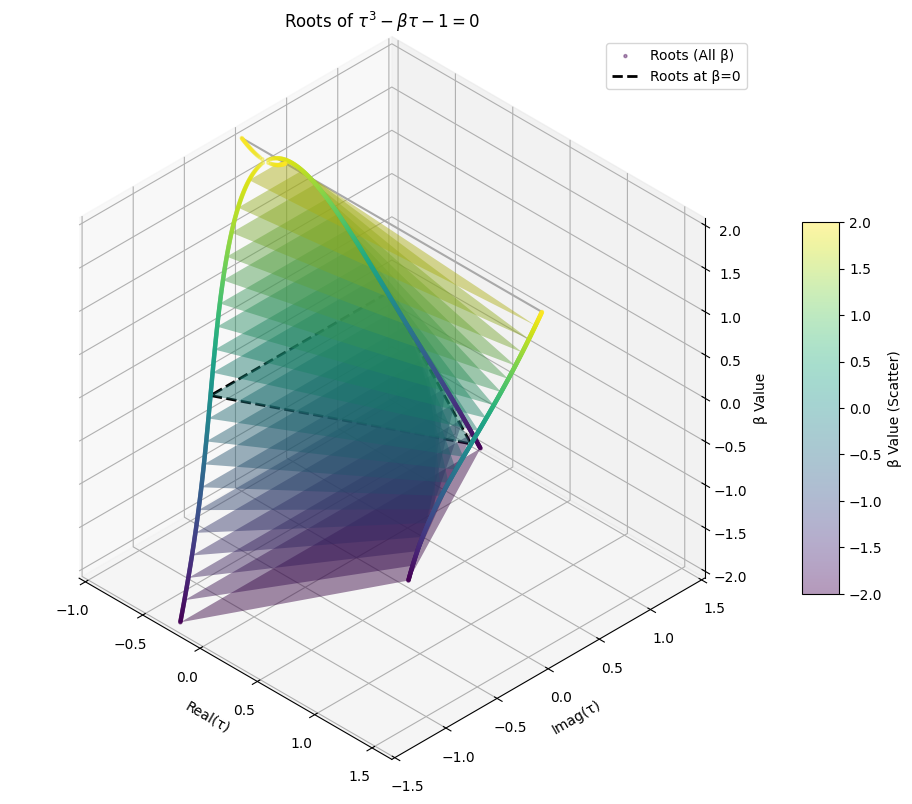

In [6]:
from matplotlib import tri
import matplotlib.cm as cm

def plot_roots_3d_notebook_refined(beta_min=-2, beta_max=2, num_betas=1001, scatter_size=5, surface_step=50, surface_alpha=0.45):
    beta_values = np.linspace(beta_min, beta_max, num_betas)
    beta_range = beta_max - beta_min

    all_roots_real = []
    all_roots_imag = []
    all_betas_for_roots = []

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_proj_type('ortho')

    for beta_val in beta_values:
        coeffs = [1, 0, -beta_val, -1]
        roots = np.roots(coeffs)
        for root in roots:
            all_roots_real.append(root.real)
            all_roots_imag.append(root.imag)
            all_betas_for_roots.append(beta_val)

    scatter_plot = ax.scatter(all_roots_real, all_roots_imag, all_betas_for_roots,
                              c=all_betas_for_roots, cmap='viridis',
                              s=scatter_size, alpha=0.4, label='Roots (All β)')

    surface_beta_indices = np.arange(0, num_betas, surface_step)
    for idx in surface_beta_indices:
        beta = beta_values[idx]
        coeffs = [1, 0, -beta, -1]
        roots = np.roots(coeffs)
        real_r = np.array([r.real for r in roots])
        imag_r = np.array([r.imag for r in roots])
        discriminant = 4 * beta**3 - 27

        beta_norm = (beta - beta_min) / beta_range if beta_range else 0.5
        current_color = cm.viridis(beta_norm)

        if discriminant > 0:
            sorted_real_roots = np.sort(real_r)
            for i in range(len(sorted_real_roots) -1):
                 ax.plot([sorted_real_roots[i], sorted_real_roots[i+1]], [0,0], [beta,beta], color='darkgray')

        else:
            if len(real_r) == 3 and len(imag_r) == 3:
                try:
                    unique_pts = np.unique(np.column_stack((real_r, imag_r)), axis=0)
                    if len(unique_pts) >= 3:
                        triang = tri.Triangulation(unique_pts[:,0], unique_pts[:,1])
                        ax.plot_trisurf(triang.x, triang.y, np.full(len(triang.x), beta),
                                        color=current_color, alpha=surface_alpha,
                                        linewidth=0.1, antialiased=True)
                    elif len(unique_pts) > 0 :
                        ax.plot(real_r, imag_r, beta, linestyle='-', marker='o', markersize=3, color=current_color, alpha=surface_alpha)

                except Exception as e:
                    ax.scatter(real_r, imag_r, beta, color=current_color, s=scatter_size*0.5, alpha=surface_alpha)

    coeffs_hl = [1, 0, 0, -1]
    roots_hl = np.roots(coeffs_hl)

    if len(roots_hl) == 3:
        real_hl = [r.real for r in roots_hl]
        imag_hl = [r.imag for r in roots_hl]
        plot_real_hl = real_hl + [real_hl[0]]
        plot_imag_hl = imag_hl + [imag_hl[0]]
        beta_hl_plane = [0] * len(plot_real_hl)
        ax.plot(plot_real_hl, plot_imag_hl, beta_hl_plane, color='black', linestyle='--', linewidth=2, alpha=1.0, label=f'Roots at β=0')

    ax.set_xlabel('Real(τ)')
    ax.set_ylabel('Imag(τ)')
    ax.set_zlabel('β Value')
    ax.set_title('Roots of $\\tau^3 - \\beta \\tau - 1 = 0$')
    ax.set_box_aspect((1,1,1))
    ax.margins(x=0, y=0, z=0)
    ax.view_init(*G45)
    ax.legend()
    fig.colorbar(scatter_plot, label='β Value (Scatter)', shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

plot_roots_3d_notebook_refined()

## Summary: Mathematical Unity in Riprompt Mechanics

This notebook has demonstrated the deep mathematical coherence underlying the riprompt system:

1. **Fixed Point Foundation**: The eigenvalues Λ_k emerge naturally as fixed points of the τ iteration, satisfying q³ + (k-2)q - 1 = 0

2. **Parameter Space Structure**: The continuous analysis across k parameter space reveals the smooth evolution of fixed point manifolds

3. **Complex Extension**: The morphic mapping generalizes the real fixed point dynamics to complex space, revealing fractal convergence patterns

4. **Algebraic Geometry**: The polynomial root visualization shows how the eigenvalue structure sits within a broader algebraic framework

Together, these visualizations reveal that the riprompt mechanics are not arbitrary constructions but emerge from fundamental mathematical structures connecting iteration dynamics, complex analysis, and algebraic geometry.